In [1]:
# Import the required packages
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


In [2]:
class FirstOrderCondRNN(nn.Module):
    def __init__(self, *, n_kc=200, n_mbon=20, n_fbn=60, n_ext=2, n_out=1,
                 f_ones=0.1, n_seed=None):
        super().__init__()

        # Set the seeds
        if n_seed is not None:
            np.random.seed(n_seed)
            torch.manual_seed(n_seed)

        # Set constants
        W_kc_mbon_max = 0.05
        self.kc_mbon_min = 0.  # Minimum synaptic weight
        self.kc_mbon_max = W_kc_mbon_max  # Maximum synaptic weight
        self.W_kc_mbon_0 = Variable(torch.ones((n_mbon, n_kc)) * W_kc_mbon_max,
                                    requires_grad=False)
        self.tau_w = 5  # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1  # Time scale of output circuitry activity
        self.n_int = 2  # Number of task intervals

        # Set the sizes of layers
        n_dan = n_mbon
        self.n_kc = n_kc
        self.n_mbon = n_mbon
        self.n_fbn = n_fbn
        self.n_dan = n_dan
        self.n_recur = n_mbon + n_fbn + n_dan
        self.n_ext = n_ext
        self.n_out = n_out
        self.n_ones = int(n_kc * f_ones)

        # Define network variables used to store data
        # Odors
        self.train_odors = None
        self.eval_odors = None
        # Training parameters (for continuation)
        self.train_T_vars = None
        self.train_rts = None
        self.train_Wts = None
        self.train_wts = None
        self.train_vts = None
        self.train_vt_opts = None
        self.train_CS_stim = None
        self.train_US_stim = None
        self.train_loss = None
        # Evaluation parameters (for plotting and analysis)
        self.eval_rts = None
        self.eval_Wts = None
        self.eval_wts = None
        self.eval_vts = None
        self.eval_vt_opts = None
        self.eval_CS_stim = None
        self.eval_US_stim = None
        self.eval_loss = None

        # Define updatable network parameters
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_mbon = torch.zeros((self.n_recur, n_mbon))
        mean_fbn = torch.zeros((self.n_recur, n_fbn))
        mean_dan = torch.zeros((self.n_recur, n_dan))
        W_mbon = torch.normal(mean_mbon, torch.sqrt(1 / (sqrt2 * n_mbon)),
                              generator=n_seed)
        W_fbn = torch.normal(mean_fbn, torch.sqrt(1 / (sqrt2 * n_fbn)),
                             generator=n_seed)
        W_dan = torch.normal(mean_dan, torch.sqrt(1 / (sqrt2 * n_dan)),
                             generator=n_seed)
        self.W_recur = nn.Parameter(torch.cat((W_mbon, W_fbn, W_dan), dim=1),
                                    requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(n_fbn, n_ext),
                                  requires_grad=True)
        mean_readout = torch.zeros((n_out, n_mbon))
        std_readout = 1 / torch.sqrt(torch.tensor(n_mbon, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout,
                                                   generator=n_seed),
                                      requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.n_recur) * 0.1,
                                 requires_grad=True)

    def forward(self, r_kc, r_ext, time, n_batch=30, W0=None, r0=None, **kwargs):
        """ Defines the forward pass of the RNN

        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Kenyon cells (r_kc i.e. 'odors').
        Feedback neurons (FBNs) receive external input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero.
        DANs receive no external input.

        Parameters
            r_kc = activity of the Kenyon cell inputs (representing odors)
            r_ext = context inputs (representing the conditioning context)
            time = time vector for a single interval
            n_batch = number of trials in mini-batch
            W0 = initial weights for KC->MBON connections
            r0 = initial activities for output circuitry neurons

        Returns
            r_recur: list of torch.ndarray(batch_size, n_mbon + n_fbn + n_dan)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, n_recur, n_recur)
                = time series of KC->MBON weights (dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        if r0 is not None:
            r_init = r0
        else:
            r_init = torch.ones(n_batch, self.n_recur) * 0.1
            r_init[:, :self.n_mbon] = 0
        r_recur = [r_init]

        # Initialize the eligibility traces and readout
        r_bar_kc = r_kc[:, :, 0]
        r_bar_dan = r_recur[-1][:, -self.n_dan:]
        readout = [torch.einsum('bom, bm -> bo',
                                self.W_readout.repeat(n_batch, 1, 1),
                                r_recur[-1][:, :self.n_mbon]).squeeze()]

        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        W_recur[:self.n_mbon, -self.n_dan:] = 0

        # Initialize the KC->MBON weights
        W_kc_mbon = [W0[0]]
        wt = [W0[1]]

        # Update activity for each time step
        for t in range(time.shape[0] - 1):
            # Define the input to the output circuitry
            I_kc_mbon = torch.einsum('bmk, bk -> bm',
                                     W_kc_mbon[-1], r_kc[:, :, t])
            I_fbn = torch.einsum('bfe, be -> bf',
                                 self.W_ext.repeat(n_batch, 1, 1),
                                 r_ext[:, :, t])
            I_tot = torch.zeros((n_batch, self.n_recur))
            I_tot[:, :self.n_mbon] = I_kc_mbon
            I_tot[:, self.n_mbon:self.n_mbon + self.n_fbn] = I_fbn

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs',
                                   W_recur.repeat(n_batch, 1, 1),
                                   r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(n_batch, 1)
                                        + I_tot)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            wt_out = self.wt_update(W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan,
                                    r_kc[:, :, t], r_recur[-1][:, -self.n_dan:],
                                    n_batch, **kwargs)
            # W_kc_mbon, wt, r_bar_kc, r_bar_dan = out
            r_bar_kc, r_bar_dan = wt_out

            # Calculate the readout (see Eq. 2)
            readout.append(torch.einsum('bom, bm -> bo',
                                        self.W_readout.repeat(n_batch, 1, 1),
                                        r_recur[-1][:, :self.n_mbon]).squeeze())

        return r_recur, (W_kc_mbon, wt), readout

    def wt_update(self, W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan, r_kc, r_dan,
                  n_batch, **kwargs):
        """ Updates the KC->MBON plasticity variables

        Synaptic weights from the Kenyon cells to the mushroom body output neurons
        (MBONs) are updated dynamically. All other weights are network parameters.
        The synaptic connections between Kenyon Cells (KCs) and MBONs are updated
        using a LTP/LTD rule (see Figure 1B of Jiang 2020), which models dopamine-
        gated neural plasticity on short time scale (behavioural learning).

        Parameters
            W_kc_mbon: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        # Calculate the eligibility traces (represent LTP/LTD)
        r_bar_kc = r_bar_kc + (r_kc - r_bar_kc) * dt / self.tau_w
        r_bar_dan = r_bar_dan + (r_dan - r_bar_dan) * dt / self.tau_w
        # Update the dynamic weight variable
        dw = self.calc_dw(r_bar_kc, r_bar_dan, r_kc, r_dan, n_batch, **kwargs)
        wt.append(wt[-1] + dw * dt)
        # Update the KC->MBON weights (see Eq. 8)
        dW = (-W_kc_mbon[-1] + wt[-1]) / self.tau_w
        W_tp1 = W_kc_mbon[-1] + dW * dt
        # Clip the KC->MBON weights to the range [0, 0.05]
        W_kc_mbon.append(torch.clamp(W_tp1, self.kc_mbon_min, self.kc_mbon_max))

        # return W_kc_mbon, wt, r_bar_kc, r_bar_dan
        return r_bar_kc, r_bar_dan

    def calc_dw(self, r_bar_kc, r_bar_dan, r_kc, r_dan, n_batch, **kwargs):
        """ Calculates the dynamic weight update (see Eq 4).

        Parameters
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch

        Returns
            update to dynamic plasticity variables wt
        """

        # Calculate the LTD/LTP terms
        prod1 = torch.einsum('bd, bk -> bdk', r_bar_dan, r_kc)
        prod2 = torch.einsum('bd, bk -> bdk', r_dan, r_bar_kc)

        return prod1 - prod2

    def run_train(self, *, opti, T_int=30, T_stim=2, dt=0.5, n_epoch=5000,
                  n_batch=30, reset_wts=True, clip=0.001, **kwargs):
        """ Trains a network on classical conditioning tasks.

        Tasks include first-order or second-order conditioning, and extinction.
        Tasks consist of two (first-order) or three (second-order and extinction)
        intervals. Each task has its own input generating function. Stimuli are
        presented between 5-15s of each interval. Neuron activities are reset
        between intervals to prevent associations being represented through
        persistent activity.

        Parameters
            opti = RNN network optimizer
            T_int = length of task intervals
            T_stim = length of time each stimulus is presented
            dt = time step of simulations
            n_epoch = number of epochs to train over
            n_batch = number of trials in mini-batch
            reset_wts = indicates whether to reset weights between trials
            clip = maximum gradient allowed during training

        Returns
            r_out_epoch = output circuit neuron activities for final epoch
            Wt_epoch = KC->MBON weights for final epoch
            vt_epoch = readout (i.e. valence) for final epoch
            vt_opt = target valence for final epoch
            loss_hist = list of losses for all epochs
            ls_stims = list of stimulus time series for plotting
        """

        # Interval time vector and time variables
        time_int = torch.arange(0, T_int + dt / 10, dt)
        T_vars = (T_int, T_stim, dt, time_int.shape[0])
        self.train_T_vars = T_vars[:-1]

        # List to store losses
        loss_hist = []

        # Initialize the KC-MBON weights
        W_in = None

        for epoch in range(n_epoch):
            # Lists to store activities, weights, readouts and target valences
            rts = []
            vts = []

            # Set the intial KC->MBON weight values for each trial
            if reset_wts or (W_in is None):
                W_in = self.init_w_kc_mbon(None, n_batch, (epoch, n_epoch))
            else:
                W_in = (W_in[0][-1].detach(), W_in[1][-1].detach())

            # Generate odor (r_kc), context (r_ext), and target valence (vt_opt)
            net_inputs = self.gen_inputs(T_vars, n_batch, **kwargs)
            r_kc, r_ext, vt_opt, ls_stims = net_inputs

            # For each interval in the task
            for i in range(self.n_int):
                # Run the forward model
                net_out = self(r_kc[i], r_ext[i], time_int, n_batch, W_in)
                rt_int, (Wt_int, wt_int), vt_int = net_out
                # Pass the KC->MBON weights to the next interval
                W_in = (Wt_int[-1], wt_int[-1])

                # Append the interval outputs to lists
                rts += rt_int
                vts += vt_int

            # Convert the list of time point values to a tensor
            #  (time is the last dimension)
            rt_epoch = torch.stack(rts, dim=-1)
            vt_epoch = torch.stack(vts, dim=-1)

            # Calculate the loss
            loss = cond_loss(vt_epoch, vt_opt, rt_epoch[:, -self.n_dan:, :])

            # Update the network parameters
            opti.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), clip)
            opti.step()

            # Print an update
            if epoch % 500 == 0:
                print(epoch, loss.item())
            loss_hist.append(loss.item())

        return loss_hist

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.

        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W_in = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            tuple of initial KC->MBON and dynamic plasticity variables
        """

        if W_in is None:
            wt0 = self.W_kc_mbon_0.repeat(n_batch, 1, 1)
            W_in = (wt0.clone(), wt0.clone())

        return W_in

    def gen_inputs(self, T_vars, n_batch, p_omit=0.3):
        """ Generates inputs for first-order conditioning tasks.

        All trials are either CS+, CS- (US omitted) or CS omitted (control trials
        to avoid over-fitting). Of the trials where CS or US is omitted, a second
        parameter determines the relative fractions of CS or US trials omitted
        (p_omit_CS). See Fig. 2 of Jiang 2020 to determine sequencing of stimuli
        during training. To account for the sequential nature of numerical
        simulations, the target valence begins one time step after stimulus
        onset. Details provided in Jiang 2020 -> Methods -> Conditioning Tasks.

        The mix of conditions is listed as follows:
            probability of CS+ trials = 1 - p_omit
            probability of CS- trials = p_omit * 0.3
            probability of control trials = p_omit * 0.7

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the range over which stimuli can be presented
        T_range = (5, 15)
        # Set the time variables
        T_stim, dt, time_len = T_vars[1:]

        # Generate odors and context signals for each trial
        r_kc, r_ext = self.gen_r_kc_ext(n_batch)

        # Determine whether CS or US are randomly omitted
        omit_inds = torch.rand(n_batch) < p_omit
        # If omitted, determine which one is omitted
        p_omit_CS = 0.7
        x_omit_CS = torch.rand(n_batch)
        omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
        omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)

        # Initialize lists to store inputs, target valence and stimulus times
        r_kct_ls = []
        r_extt_ls = []
        vals = []
        ls_CS = []
        ls_US = []

        # For each interval
        for i in range(self.n_int):
            # Initialize time matrices
            time_CS = torch.zeros(n_batch, time_len)
            time_US = torch.zeros_like(time_CS)
            val_int = torch.zeros_like(time_CS)

            # Calculate the stimulus presentation times and length
            st_times, st_len = gen_int_times(n_batch, dt, T_stim, T_range)

            for b in range(n_batch):
                stim_inds = st_times[b] + torch.arange(st_len)
                # Set the CS input times
                if not omit_CS_inds[b]:
                    time_CS[b, stim_inds] = 1
                # Set the US input times
                if i == 0 and not omit_US_inds[b]:
                    time_US[b, (stim_inds + st_len)] = 1
                # Set the target valence times
                if i == 1 and not omit_inds[b]:
                    if r_ext[b, 0] == 1:
                        val_int[b, (stim_inds + 1)] = 1
                    else:
                        val_int[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                                 time_CS.repeat(self.n_kc, 1, 1))
            r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                                  time_US.repeat(self.n_ext, 1, 1))

            r_kct_ls.append(r_kct)
            r_extt_ls.append(r_extt)
            vals.append(val_int)
            ls_CS += time_CS
            ls_US += time_US

        # Concatenate target valences
        vt_opt = torch.cat((vals[0], vals[1]), dim=-1)

        # Make a list of stimulus times to plot
        ls_stims = [torch.cat(ls_CS), torch.cat(ls_US)]

        return r_kct_ls, r_extt_ls, vt_opt, ls_stims

    def run_eval(self, *, trial_ls, T_int=30, T_stim=2, dt=0.5, n_trial=1,
                 n_batch=1, reset_wts=True, **kwargs):
        """ Runs an evaluation based on a series of input functions

        Parameters
            trial_ls = list of interval functions that compose a trial
            T_int = length of a task interval (in seconds)
            T_stim = length of time each stimulus is presented
            dt = time step of simulation (in seconds)
            n_trial = number of trials to run
            n_batch = number of parallel trials in a batch
            reset_wts = indicates whether to reset weights between trials
        """

        # Reset lists storing evaluation data
        self.eval_rts = []
        self.eval_Wts = []
        self.eval_wts = []
        self.eval_vts = []
        self.eval_vt_opts = []
        self.eval_CS_stim = []
        self.eval_US_stim = []
        self.eval_loss = []

        # Interval time vector
        time_int = torch.arange(0, T_int + dt / 10, dt)
        t_len = time_int.shape[0]
        n_int = len(trial_ls)

        # Initialize the KC-MBON weights and plasticity variable
        W_in = None

        # For each function in the list, run an interval
        # All intervals together compose a single trial
        for trial in range(n_trial):
            # Lists to store activities, weights, readouts and target valences
            rts = []
            Wts = []
            wts = []
            vts = []
            vt_opts = []
            time_CS = []
            time_US = []

            # Determine whether to reset KC->MBON weights between trials
            if reset_wts or (W_in is None):
                W_in = self.init_w_kc_mbon(None, n_batch, (trial, n_trial))
            else:
                W_in = (W_in[0][-1].detach(), W_in[1][-1].detach())

            # Generate odors and context (odor = KC = CS, context = ext = US)
            r_kc0, r_ext0 = self.gen_r_kc_ext(n_batch, **kwargs)
            trial_odors = [r_kc0]
            r_in = ([r_kc0], r_ext0)

            # Store the max number of CS stimuli across all intervals
            max_num_CS = 1
            max_num_US = 1

            for i in range(n_int):
                # Calculate the CS stimulus presentation times
                st_times, st_len = gen_int_times(n_batch, dt, T_stim, **kwargs)

                # Select the interval function to run
                int_fnc = trial_ls[i]
                # Calculate the interval inputs
                f_in = int_fnc(t_len, st_times, st_len, r_in, n_batch,
                               T_stim=T_stim, dt=dt, **kwargs)
                r_in, r_kct, r_extt, stim_ls, vt_opt = f_in

                # Run the forward pass
                net_out = self(r_kct, r_extt, time_int, n_batch, W_in)
                rt_int, (Wt_int, wt_int), vt_int = net_out
                # Pass the KC->MBON weights to the next interval
                W_in = (Wt_int[-1], wt_int[-1])

                # Append the interval outputs to lists
                rts += rt_int
                Wts += Wt_int
                wts += wt_int
                vts += vt_int
                vt_opts.append(vt_opt)
                time_CS.append(stim_ls[0])
                time_US.append(stim_ls[1])

                # Update max number of CS
                max_num_CS = max(max_num_CS, len(stim_ls[0]))
                max_num_US = max(max_num_US, len(stim_ls[1]))

            # # If the odors are not static for all trials, save odors
            # if not self.static_odors:
            #     # self.eval_odors.append(r_kc)
            #     self.eval_odors.append(trial_odors)

            # Convert the lists of time point values to a tensor,
            # time is the last dimension
            self.eval_rts.append(torch.stack(rts, dim=-1).detach())
            self.eval_Wts.append(torch.stack(Wts, dim=-1).detach())
            self.eval_wts.append(torch.stack(wts, dim=-1).detach())
            self.eval_vts.append(torch.stack(vts, dim=-1).detach())
            self.eval_vt_opts.append(torch.cat(vt_opts, dim=-1).detach())

            # TODO: This is messy, clean up this storage method
            # Concatenate time lists to store
            trial_CSs = []
            for i in range(max_num_CS):
                CS_vec = torch.zeros(n_batch, t_len * n_int)
                for j in range(n_int):
                    try:
                        CS_vec[:, j * t_len:(j + 1) * t_len] = time_CS[j][i]
                    except IndexError:
                        pass
                trial_CSs.append(CS_vec)

            trial_USs = []
            for i in range(max_num_US):
                US_vec = torch.zeros(n_batch, t_len * n_int)
                for j in range(n_int):
                    try:
                        US_vec[:, j * t_len:(j + 1) * t_len] = time_US[j][i]
                    except IndexError:
                        pass
                trial_USs.append(US_vec)

            # Store the time series lists
            self.eval_CS_stim.append(trial_CSs)
            self.eval_US_stim.append(trial_USs)

            # TODO: I think the loss function fails for batch sizes of 1
            # Calculate the loss
            # print(self.eval_vts[-1].shape)
            # print(self.eval_vt_opts[-1].shape)
            # print(self.eval_rts[-1][:, -self.n_dan:, :].shape)
            loss = cond_loss(self.eval_vts[-1], self.eval_vt_opts[-1],
                             self.eval_rts[-1][:, -self.n_dan:, :])
            self.eval_loss.append(loss.item())

    def gen_r_kc_ext(self, n_batch, pos_val=None, **kwargs):
        """ Generates neuron activations for context and odor inputs.

        Parameters
            n_batch = number of trials in eval-batch
            pos_vt (kwarg) = indicates whether valence should be positive
                             None: random valence
                             True: positive valence
                             False: negative valence
        """

        # Determine the contextual input (r_ext)
        if pos_val is None:
            r_ext = torch.multinomial(torch.ones(n_batch, self.n_ext),
                                      self.n_ext)
        elif pos_val:
            r_ext = torch.tensor([1, 0]).repeat(n_batch, 1)
        elif not pos_val:
            r_ext = torch.tensor([0, 1]).repeat(n_batch, 1)
        else:
            raise Exception('Not a valid value for pos_val')

        # Determine odor input (r_kc)
        r_kc = torch.zeros(n_batch, self.n_kc)
        for b in range(n_batch):
            # Define an odor (CS) for each trial
            if self.train_odors is not None:
                n_odors = self.train_odors.shape[0]
                odor_select = torch.randint(n_odors, (1,))
                r_kc_inds = self.train_odors[odor_select, :]
            else:
                r_kc_inds = torch.multinomial(torch.ones(self.n_kc), self.n_ones)
            r_kc[b, r_kc_inds] = 1

        return r_kc, r_ext


In [3]:
class ExtendedCondRNN(FirstOrderCondRNN):
    def __init__(self):
        super().__init__()
        # Set the number of task intervals
        self.n_int = 3

    def gen_inputs(self, T_vars, n_batch, p_omit=0.5):
        """ Generates inputs for extinction and second-order tasks.

        Trials are either extinction or second-order conditioning. No strictly
        first-order conditioning trials are included. In half of trials, CS or US
        are omitted (pg 28 of Jiang 2020) to prevent over-fitting. Of the trials
        where CS or US is omitted, a second parameter determines the relative
        fractions of CS or US trials omitted (p_omit_CS).

        There are no explicit first-order conditioning tasks included, since
        first-order conditioning is a necessary part of both extinction and
        second-order conditioning. See Figure 2 of Jiang 2020 to determine
        sequencing of stimuli during training. To account for the sequential
        nature of numerical simulations, the target valence is set to begin one
        time step after stimulus onset.

        The mix of conditions is listed as follows:
            probability of extinction trials = p_extinct = 0.5
            probability of second-order conditioning trials = 1 - p_extinct = 0.5
            probability of control (US omitted = CS-) trials = p_omit * 0.3
            probability of control (CS omitted) trials = p_omit * 0.7
        Note: extinction and second-order trials overlap arbitrarily with
              control trials

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the range over which stimuli can be presented
        T_range = (5, 15)
        # Set the time variables
        T_stim, dt, time_len = T_vars[1:]

        # Generate odors and context signals for each trial
        r_kc1, r_ext = self.gen_r_kc_ext(n_batch)
        r_kc2, _ = self.gen_r_kc_ext(n_batch)

        # Determine whether trials are extinction or second-order
        p_extinct = 0.5
        extinct_inds = torch.rand(n_batch) < p_extinct

        # Determine whether CS or US are randomly omitted
        omit_inds = torch.rand(n_batch) < p_omit
        # If omitted, determine which one is omitted
        p_omit_CS = 0.7
        x_omit_CS = torch.rand(n_batch)
        omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
        omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)

        # Initialize lists to store inputs and target valence
        r_kct_ls = []
        r_extt_ls = []
        vals = []
        ls_CS1 = []
        ls_CS2 = []
        ls_US = []

        # For each interval
        for i in range(self.n_int):
            # Define a binary CS and US time series to mulitply the inputs by
            time_CS1 = torch.zeros(n_batch, time_len)
            time_CS2 = torch.zeros_like(time_CS1)
            time_US = torch.zeros_like(time_CS1)
            # Define the target valences
            val_int = torch.zeros_like(time_CS1)

            # Calculate the stimulus presentation times and length
            st_times, st_len = gen_int_times(n_batch, dt, T_stim, T_range)

            # Set the inputs for each trial
            for b in range(n_batch):
                stim_inds = st_times[b] + torch.arange(st_len)
                # Set the inputs for extinction trials
                if extinct_inds[b]:
                    # Set the CS input times
                    if not omit_CS_inds[b]:
                        time_CS1[b, stim_inds] = 1
                    # Set the US input times
                    if i == 0 and not omit_US_inds[b]:
                        time_US[b, stim_inds + st_len] = 1
                    # Set the target valence times
                    if i > 0 and not omit_inds[b]:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + 1)] = 1 / i
                        else:
                            val_int[b, (stim_inds + 1)] = -1 / i
                # Set the inputs for second-order conditioning trials
                else:
                    # Set the CS1 and CS2 input times
                    if not omit_CS_inds[b]:
                        if i == 0:
                            time_CS1[b, stim_inds] = 1
                        if i == 1:
                            time_CS1[b, stim_inds + st_len] = 1
                            time_CS2[b, stim_inds] = 1
                        if i == 2:
                            time_CS2[b, stim_inds] = 1
                    # Set the US input times
                    if i == 0 and not omit_US_inds[b]:
                        time_US[b, stim_inds + st_len] = 1
                    # Set the target valence times
                    if i > 0 and not omit_inds[b]:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + (i % 2) * st_len + 1)] = 1
                        else:
                            val_int[b, (stim_inds + (i % 2) * st_len + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct = torch.einsum('bm, mbt -> bmt', r_kc1,
                                 time_CS1.repeat(self.n_kc, 1, 1))
            r_kct += torch.einsum('bm, mbt -> bmt', r_kc2,
                                  time_CS2.repeat(self.n_kc, 1, 1))
            r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                                  time_US.repeat(self.n_ext, 1, 1))

            r_kct_ls.append(r_kct)
            r_extt_ls.append(r_extt)
            vals.append(val_int)
            ls_CS1 += time_CS1
            ls_CS2 += time_CS2
            ls_US += time_US

        # Concatenate target valences
        vt_opt = torch.cat((vals[0], vals[1], vals[2]), dim=-1)

        # Make a list of stimulus times to plot
        ls_stims = [torch.cat(ls_CS1), torch.cat(ls_US), torch.cat(ls_CS2)]

        return r_kct_ls, r_extt_ls, vt_opt, ls_stims


In [4]:
class NoPlasticityRNN(FirstOrderCondRNN):
    def __init__(self, *, n_odors=10):
        super().__init__()
        # Set the static KC->MBON weights
        W_kc_mbon_max = 0.05
        self.W_kc_mbon = Variable(torch.rand(self.n_mbon, self.n_kc) *
                                  W_kc_mbon_max, requires_grad=False)
        # Generate a static list of odors for the network to train on
        self.train_odors = torch.multinomial(torch.ones(n_odors, self.n_kc),
                                             self.n_ones)
        # Set the number of task intervals
        self.n_int = 1

    def wt_update(self, W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan, r_kc, r_dan,
                  n_batch, **kwargs):
        """ Returns directly the static KC->MBON plasticity variables

        Since this class has no plasticity, the KC->MBON weights and plasticity
        variables are not updated. Therefore, the values are returned directly.

        Parameters
            W_kc_MBON: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        return r_bar_kc, r_bar_dan

    def gen_inputs(self, T_vars, n_batch, **kwargs):
        """ Generates inputs for task without KC->MBON plasticity.

        All trials are CS+ or control trials where CS+ is switched out for a
        neutral CS in the second presentation (CS- trials). In the case where the
        CS is switched, the target valence is zero. To account for the sequential
        nature of numerical simulations, the target valence is set to begin one
        time step after stimulus onset.

        The mix of conditions is listed as follows:
            probability of trials where CS+ is switched = 0.5

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the range over which stimuli can be presented
        T_range = [(5, 15), (20, 30)]
        # Set the time variables
        T_stim, dt, time_len = T_vars[1:]

        # Generate odors and context signals for each trial
        r_kc, r_ext = self.gen_r_kc_ext(n_batch, **kwargs)

        # Determine whether CS2+ is switched (switch on half of trials)
        switch_inds = torch.rand(n_batch) < 0.5

        # Initialize activity matrices
        r_kct = torch.zeros(n_batch, self.n_kc, time_len)
        r_extt = torch.zeros(n_batch, self.n_ext, time_len)
        time_CS_both = torch.zeros(n_batch, time_len)
        time_US = torch.zeros_like(time_CS_both)
        vt_opt = torch.zeros_like(time_CS_both)

        # For each stimulus presentation
        for i in range(2):
            # Initialize time matrices
            time_CS = torch.zeros(n_batch, time_len)

            # Calculate the stimulus presentation times and length
            st_times, st_len = gen_int_times(n_batch, dt, T_stim, T_range[i])

            for b in range(n_batch):
                stim_inds = st_times[b] + torch.arange(st_len)
                # Set the CS time
                time_CS[b, stim_inds] = 1
                # Set the US time
                if i == 0:
                    time_US[b, stim_inds + st_len] = 1
                # Set the CS+/CS2 and target valence times
                if i == 1:
                    # Switch the odor in half the trials (target valence is zero)
                    if switch_inds[b]:
                        # CS2_inds = torch.multinomial(torch.ones(self.n_kc),
                        #                              self.n_ones)
                        # r_kc[b, CS2_inds] = 1
                        CS2_inds = torch.multinomial(torch.ones(self.n_kc),
                                                     self.n_kc)
                        r_kc[b, :] = r_kc[b, CS2_inds]
                    # If the odor is not switched, set the target valence
                    else:
                        if r_ext[b, 0] == 1:
                            vt_opt[b, (stim_inds + 1)] = 1
                        else:
                            vt_opt[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct += torch.einsum('bm, mbt -> bmt', r_kc,
                                  time_CS.repeat(self.n_kc, 1, 1))
            r_extt += torch.einsum('bm, mbt -> bmt', r_ext,
                                   time_US.repeat(self.n_ext, 1, 1))
            time_CS_both += time_CS

        # Make a list of stimulus times to plot
        ls_stims = [time_CS_both, time_US]

        return [r_kct], [r_extt], vt_opt, ls_stims


In [5]:
class ContinualRNN(FirstOrderCondRNN):
    def __init__(self, *, n_trial_odors=4):
        super().__init__()
        # Set the number of task intervals
        self.n_int = 1
        # Set the number of odors to train over on each trial
        self.n_trial_odors = n_trial_odors
        # Add a non-specific potentiation parameter
        self.beta = nn.Parameter(torch.ones(self.n_kc) * 0.01,
                                 requires_grad=True)

    def calc_dw(self, r_bar_kc, r_bar_dan, r_kc, r_dan, n_batch, nps=True,
                **kwargs):
        """ Calculates the dynamic weight update (see Eq 4).

        Parameters
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
            nps = indicates whether non-specific potentiation is included

        Returns
            dw = increment of dynamic plasticity variable wt
        """

        # Calculate the LTD/LTP terms
        prod1 = torch.einsum('bd, bk -> bdk', r_bar_dan, r_kc)
        prod2 = torch.einsum('bd, bk -> bdk', r_dan, r_bar_kc)

        # Include non-specific potentiation (unless control condition)
        if nps:
            # Rectify the potentiation parameter
            beta = F.relu(self.beta.clone())
            # Constrain the potentiation parameter to be positive
            prod3 = torch.einsum('bd, bk -> bdk', r_bar_dan,
                                 beta.repeat(n_batch, 1))
        else:
            prod3 = torch.zeros_like(prod2)

        return prod1 - prod2 + prod3

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.

        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W0 = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            W_kc_MBON: list = initial KC->MBON weight matrix
            wt = initial dynamic plasticity update
        """

        wt0 = torch.ones(n_batch, self.n_mbon, self.n_kc) * self.kc_mbon_max
        if W_in is None:
            W_in = (wt0.clone(), wt0.clone())
        # Calculate the saturation parameter and modify initial weights
        x_sat = min(1, (e_tup[0] / (e_tup[1] / 2)))
        Wt = W_in[0]
        wt = (1 - x_sat) * wt0 + x_sat * W_in[1]
        W_in = (Wt, wt)

        return W_in

    def gen_inputs(self, T_vars, n_batch, **kwargs):
        """ Generates inputs for continual learning task.

        Trials consist of the presentation of four different odors, with
        presentation times drawn from a Poisson distribution with a mean of two.
        The first two odors are conditioned stimuli, with the first
        corresponding to a positive valence (approach behaviour) and the second
        corresponding to a negative valence (avoidance behaviour). The last two
        are neutral odors and have zero associated valence. The conditioned
        stimuli are trained to respond (i.e. have a non-zero target valence) to
        each presentation of the odor AFTER the first.

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the time variables
        T_int, T_stim, dt, time_len = T_vars
        # Average number of stimulus presentations
        st_mean = 2
        # Calculate the stimulus presentation times and length
        st_times, st_len = gen_cont_times(n_batch, dt, T_stim, T_int, st_mean,
                                          self.n_trial_odors)

        # Initialize activity matrices
        r_kct = torch.zeros(n_batch, self.n_kc, time_len)
        r_extt = torch.zeros(n_batch, self.n_ext, time_len)

        # Initialize lists and arrays to store stimulus time series
        ls_CS = []
        time_US_all = torch.zeros(n_batch, time_len)
        vt_opt = torch.zeros(n_batch, time_len)

        # For each batch, randomly generate different odors and presentation times
        for i in range(self.n_trial_odors):
            # Initialize the CS time matrix
            time_CS = torch.zeros(n_batch, time_len)
            time_US = torch.zeros_like(time_CS)

            # Generate odors and context signals for each trial
            if i == 0:
                r_kc, r_ext = self.gen_r_kc_ext(n_batch, pos_val=True)
            elif i == 1:
                r_kc, r_ext = self.gen_r_kc_ext(n_batch, pos_val=False)
            else:
                r_kc, r_ext = self.gen_r_kc_ext(n_batch)
                r_ext = torch.tensor([0, 0]).repeat(n_batch, 1)

            # For each trial
            for b in range(n_batch):
                for j, st in enumerate(st_times[i][b]):
                    # Set the CS input times
                    stim_inds = st + torch.arange(st_len)
                    time_CS[b, stim_inds] = 1

                    # For CS+ odors, set US and the valence
                    if i < (self.n_trial_odors / 2):
                        # Set the US input times
                        time_US[b, (stim_inds + st_len)] = 1
                        # Set target valence on every presentation but the first
                        if j > 0:
                            if r_ext[b, 0] == 1:
                                vt_opt[b, (stim_inds + 1)] = 1
                            else:
                                vt_opt[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct += torch.einsum('bm, mbt -> bmt', r_kc,
                                  time_CS.repeat(self.n_kc, 1, 1))
            r_extt += torch.einsum('bm, mbt -> bmt', r_ext,
                                   time_US.repeat(self.n_ext, 1, 1))
            ls_CS += time_CS
            time_US_all += time_US

        # Make a list of stimulus times to plot
        ls_stims = ls_CS + [time_US_all]

        return [r_kct], [r_extt], vt_opt, ls_stims


In [6]:
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.

    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eqs. (3) and (9) in Jiang 2020.

    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant

    Returns
        loss_tot = scalar loss used in backprop
    """

    # Set the baseline DAN activity
    DAN_baseline = 0.1

    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt) ** 2, dim=1)
    v_loss = torch.mean(v_sum)

    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - DAN_baseline) ** 2, dim=1)
    r_loss = torch.mean(r_sum, dim=1) * lam

    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss

    # Average the loss over all batches
    loss_tot = torch.mean(loss)

    return loss_tot


def first_order_cond_csp(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs a first-order conditioning interval (CS+ and US).

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
        p_ctrl (kwarg) = fraction of control trials during training
        p_csm (kwarg) = fraction of control trials that are CS-
    """

    # Set odors and context signals for this interval
    r_kcs, r_ext = r_in
    r_kc = r_kcs[0]
    n_kc = r_kc.shape[1]
    n_ext = r_ext.shape[1]

    # Initialize stimulus time matrices
    time_CS = torch.zeros(n_batch, t_len)
    time_US = torch.zeros_like(time_CS)
    vt_opt = torch.zeros_like(time_CS)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS[b, stim_inds] = 1
        # Set the US input times
        time_US[b, (stim_inds + st_len)] = 1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                         time_CS.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    stim_ls = [[time_CS], time_US]

    return r_in, r_kct, r_extt, stim_ls, vt_opt


def first_order_csm(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs a first-order conditioning interval (CS- alone).

    This function can be used for both the conditioning and test intervals
    of CS- trials. Only the CS stimulus is presented.

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc = r_kcs[0]
    n_kc = r_kc.shape[1]
    n_ext = r_ext.shape[1]

    # Initialize stimulus time matrices
    time_CS = torch.zeros(n_batch, t_len)
    time_US = torch.zeros_like(time_CS)
    vt_opt = torch.zeros_like(time_CS)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS[b, stim_inds] = 1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                         time_CS.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    stim_ls = [[time_CS], time_US]

    return r_in, r_kct, r_extt, stim_ls, vt_opt


def first_order_test(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs a first-order test interval (CS+ and target valence).

    This function can be used for both first--order tests and extinction
    conditioning. This interval must follow an interval with a single odor.
    i.e. the input r_kc must be of size (n_batch, n_kc)

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc = r_kcs[0]
    n_kc = r_kc.shape[1]
    n_ext = r_ext.shape[1]

    # Initialize stimulus time matrices
    time_CS = torch.zeros(n_batch, t_len)
    time_US = torch.zeros_like(time_CS)
    vt_opt = torch.zeros_like(time_CS)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS[b, stim_inds] = 1
        # Set the target valence times
        if r_ext[b, 0] == 1:
            vt_opt[b, (stim_inds + 1)] = 1
        else:
            vt_opt[b, (stim_inds + 1)] = -1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                         time_CS.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    stim_ls = [[time_CS], time_US]

    return r_in, r_kct, r_extt, stim_ls, vt_opt


def extinct_test(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs an extinction interval.

    Consists of CS+ stimulus presentation without the relevant US. The
    extinction test always occurs after a first order test. In this case,
    the target valence is half that of a first order (CS+) test.

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc = r_kcs[0]
    n_kc = r_kc.shape[1]
    n_ext = r_ext.shape[1]

    # Initialize stimulus time matrices
    time_CS = torch.zeros(n_batch, t_len)
    time_US = torch.zeros_like(time_CS)
    vt_opt = torch.zeros_like(time_CS)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS[b, stim_inds] = 1
        # Set the target valence times
        if r_ext[b, 0] == 1:
            vt_opt[b, (stim_inds + 1)] = 1 / 2
        else:
            vt_opt[b, (stim_inds + 1)] = -1 / 2

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                         time_CS.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    stim_ls = [[time_CS], time_US]

    return r_in, r_kct, r_extt, stim_ls, vt_opt


def second_order_cond(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs a first-order conditioning interval (CS alone).

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc1 = r_kcs[0]
    n_kc = r_kc1.shape[1]
    n_ext = r_ext.shape[1]
    # Initialize a second odor
    r_kc2 = torch.zeros_like(r_kc1)
    n_ones = r_kc1[0, :].sum().int()

    # Initialize stimulus time matrices
    time_CS1 = torch.zeros(n_batch, t_len)
    time_CS2 = torch.zeros_like(time_CS1)
    time_US = torch.zeros_like(time_CS1)
    vt_opt = torch.zeros_like(time_CS1)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Shuffle the indices to create a new second odor
        new_inds = torch.multinomial(torch.ones(n_ones), n_ones)
        r_kc2[b, :] = r_kc1[b, new_inds]

        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS1 input times
        time_CS1[b, stim_inds] = 1
        # Set the CS2 input times
        time_CS2[b, (stim_inds + st_len)] = 1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc1,
                         time_CS1.repeat(n_kc, 1, 1))
    r_kct += torch.einsum('bm, mbt -> bmt', r_kc2,
                          time_CS2.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    time_all_CS = [time_CS1, time_CS2]
    stim_ls = [time_all_CS, time_US]
    r_next = ([r_kc1, r_kc2], r_ext)

    return r_next, r_kct, r_extt, stim_ls, vt_opt


def second_order_test(t_len, st_times, st_len, r_in, n_batch, **kwargs):
    """ Runs a first-order test interval (CS+ and target valence).

    This function can be used for both first- and second-order tests, as well
    as extinction conditioning.

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc = r_kcs[1]
    n_kc = r_kc.shape[1]
    n_ext = r_ext.shape[1]

    # Initialize stimulus time matrices
    time_CS1 = torch.zeros(n_batch, t_len)
    time_CS2 = torch.zeros_like(time_CS1)
    time_US = torch.zeros_like(time_CS1)
    vt_opt = torch.zeros_like(time_CS1)

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds = st_times[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS2[b, stim_inds] = 1
        # Set the target valence times
        if r_ext[b, 0] == 1:
            vt_opt[b, (stim_inds + 1)] = 1
        else:
            vt_opt[b, (stim_inds + 1)] = -1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                         time_CS2.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    time_all_CS = [time_CS1, time_CS2]
    stim_ls = [time_all_CS, time_US]

    return r_in, r_kct, r_extt, stim_ls, vt_opt


def no_plasticity_trial(t_len, st_times, st_len, r_in, n_batch, T_stim,
                        dt, p_ctrl=0., **kwargs):
    """ Runs a full no-plasticity trial (CS+ and US).

    In half of the training trials, the second odor is switched to prevent
    over-generalization.

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
        p_ctrl = fraction of control (generalization) trials
    """

    # Generates a second set of stimulus times for the second presentation
    st_times2, _ = gen_int_times(n_batch, dt, T_stim, T_range=(20, 30))

    # Set odors and context signals for each trial
    r_kcs, r_ext = r_in
    r_kc1 = r_kcs[0]
    n_kc = r_kc1.shape[1]
    n_ext = r_ext.shape[1]
    # Define a second set of odors for generalization trials
    # r_kc2 = r_kc1.clone()
    r_kc2 = torch.zeros_like(r_kc1)
    n_ones = r_kc1[0, :].sum().int()

    # Initialize stimulus time matrices
    time_CS1 = torch.zeros(n_batch, t_len)
    time_CS2 = torch.zeros_like(time_CS1)
    time_US = torch.zeros_like(time_CS1)
    vt_opt = torch.zeros_like(time_CS1)

    # Determine whether CS+ is switched for a novel odor
    switch_inds = torch.rand(n_batch) < p_ctrl

    # Set the stimulus step inputs
    for b in range(n_batch):
        # Convert stimulus time into range of indices
        stim_inds1 = st_times[b] + torch.arange(st_len)
        stim_inds2 = st_times2[b] + torch.arange(st_len)
        # Set the CS input times
        time_CS1[b, stim_inds1] = 1

        # If it is a control trial, switch the odor (target valence is zero)
        if switch_inds[b]:
            time_CS2[b, stim_inds2] = 1
            new_inds = torch.multinomial(torch.ones(n_kc), n_ones)
            # r_kc2[b, :] = r_kc1[b, new_inds]
            r_kc2[b, new_inds] = 1
        # If the odor is not switched, set the target valence
        else:
            time_CS1[b, stim_inds2] = 1
            if r_ext[b, 0] == 1:
                vt_opt[b, (stim_inds2 + 1)] = 1
            else:
                vt_opt[b, (stim_inds2 + 1)] = -1

    # Calculate the input neurons' activity time series (KC = CS, ext = US)
    r_kct = torch.einsum('bm, mbt -> bmt', r_kc1,
                         time_CS1.repeat(n_kc, 1, 1))
    r_kct += torch.einsum('bm, mbt -> bmt', r_kc2,
                          time_CS2.repeat(n_kc, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                          time_US.repeat(n_ext, 1, 1))

    # Combine the time matrices into a list
    time_all_CS = [time_CS1, time_CS2]
    stim_ls = [time_all_CS, time_US]
    r_next = ([r_kc1, r_kc2], r_ext)

    return r_next, r_kct, r_extt, stim_ls, vt_opt


def continual_trial(t_len, st_times, st_len, r_in, n_batch, dt, **kwargs):
    """ Runs a continual learning trial (two CS- and two CS+).

    Parameters
        t_len = length of task interval (in indices)
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
        r_in = input neuron activations (r_kc and r_ext)
        n_batch = number of trials in batch
    """

    # Draw the CS presentation times from a Poisson distribution
    st_times, st_len = gen_cont_times(n_batch, dt, **kwargs)
    n_odor = len(st_times)

    # Set odors and context signals
    r_kc, r_ext0 = r_in
    r_kc0 = r_kc[0]
    # Define the number of Kenyon cells (n_kc) and dim of context (n_ext)
    n_kc = r_kc0.shape[1]
    n_ext = r_ext0.shape[1]
    n_ones = r_kc0[0, :].sum().int()
    # Initialize lists to store additional odors and their context signals
    r_kcs = [torch.tensor([0])] * n_odor
    r_exts = [torch.tensor([0])] * n_odor
    # The first US is appetitive, while the second is aversive
    r_exts[0] = torch.tensor([1, 0]).repeat(n_batch, 1)
    r_exts[1] = torch.tensor([0, 1]).repeat(n_batch, 1)

    # Initialize activity matrices
    r_kct = torch.zeros(n_batch, n_kc, t_len)
    r_extt = torch.zeros(n_batch, n_ext, t_len)

    # Initialize stimulus time matrices
    # time_CS = torch.zeros(n_odor, n_batch, t_len)
    # time_US = torch.zeros_like(time_CS)
    time_all_CS = []
    time_all_US = []
    vt_opt = torch.zeros(n_batch, t_len)

    # Set the stimulus step inputs
    for i in range(n_odor):
        # Initialize time matrices
        time_CS = torch.zeros(n_batch, t_len)
        time_US = torch.zeros_like(time_CS)
        append_US = False
        # Set neutral stimulus contexts
        r_kcs[i] = torch.zeros_like(r_kc0)
        if i > 1:
            r_exts[i] = torch.tensor([0, 0]).repeat(n_batch, 1)

        for b in range(n_batch):
            # Generate odors
            # new_kc_inds = torch.multinomial(torch.ones(n_kc), n_kc)
            # r_kcs[i][b, :] = r_kc0[b, new_kc_inds]
            new_kc_inds = torch.multinomial(torch.ones(n_kc), n_ones)
            r_kcs[i][b, new_kc_inds] = 1

            for j, st in enumerate(st_times[i][b]):
                # Convert stimulus time into range of indices
                stim_inds = st + torch.arange(st_len)
                # Set the CS input times
                time_CS[b, stim_inds] = 1

                if i < (n_odor / 2):
                    # Set the US input times
                    time_US[b, (stim_inds + st_len)] = 1
                    append_US = True
                    # Set target valence on each presentation after the first
                    if j > 0:
                        if r_exts[i][b, 0] == 1:
                            vt_opt[b, (stim_inds + 1)] = 1
                        else:
                            vt_opt[b, (stim_inds + 1)] = -1

        # Calculate the input neuron activity time series (KC = CS, ext = US)
        r_kct += torch.einsum('bm, mbt -> bmt', r_kcs[i],
                              time_CS.repeat(n_kc, 1, 1))
        r_extt += torch.einsum('bm, mbt -> bmt', r_exts[i],
                               time_US.repeat(n_ext, 1, 1))

        # Save the CS and US stimuli time series
        # time_all_CS[i, :, :] = time_CS
        # time_all_US[i, :, :] = time_US
        time_all_CS.append(time_CS)
        if append_US:
            time_all_US.append(time_US)

    # Combine the time matrices into a list
    stim_ls = [time_all_CS, time_all_US]
    r_next = (r_kcs, r_exts)

    return r_next, r_kct, r_extt, stim_ls, vt_opt


def gen_int_times(n_batch, dt, T_stim, T_range=(5, 15), **kwargs):
    """ Generates an array of stimulus presentation times for all trials

    Parameters
        dt = time step of simulations
        n_batch = number of trials in eval-batch
        T_stim = length of time each stimulus is presented
        T_range: tuple = range in which stimulus can be presented

    Returns
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
    """

    # Present the stimulus between 5-15s of each interval
    min_ind = int(T_range[0] / dt)
    max_ind = int((T_range[1] - 2 * T_stim) / dt)
    st_times = torch.randint(min_ind, max_ind, (n_batch,))
    st_len = int(T_stim / dt)

    return st_times, st_len


def gen_cont_times(n_batch, dt, T_stim=2, T_int=200, stim_mean=2, n_odor=4,
                   **kwargs):
    """ Generates stimulus presentation times for continual learning trials.

    Parameters
        dt = time step of simulations
        n_batch = number of trials in eval-batch
        T_stim = length of time each stimulus is presented
        T_int (kwarg) = length of trial (in seconds)
        stim_mean (kwarg) = average number of stimulus presentations per trial
        n_odor = number of odors in a trial

    Returns
        st_times = lists of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
    """

    # Poisson rate of stimulus presentations
    stim_rate = stim_mean / T_int

    # Initialize stimulus presentation times array
    st_times = [torch.tensor([0])] * n_odor
    st_len = int(T_stim / dt)

    # Generate a list of stimulus presentation times for each trial
    for i in range(n_odor):
        batch_times = [torch.tensor([0])] * n_batch
        for b in range(n_batch):
            trial_times = []
            last_time = 0
            while True:
                stim_isi = -torch.log(torch.rand(1)) / stim_rate
                next_time = last_time + stim_isi
                if next_time < (T_int - 2 * T_stim):
                    # Stimulus times are indices (not times)
                    trial_times.append((next_time / dt).int())
                    last_time += stim_isi
                # Ensure at least one presentation of each stimuli
                elif last_time == 0:
                    continue
                else:
                    break
            batch_times[b] = torch.stack(trial_times)
        st_times[i] = batch_times

    return st_times, st_len


In [7]:
def plot_trial(network, trial_ls, plt_ttl, plt_lbl, T_vars, **kwargs):
    """ Plots a figure similar to Figure 2 from Jiang 2020.

    Runs the network using a novel combination of stimuli, then prints the
    result. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen
    mushroom body output neurons (MBONs).

    Paramters
        network = previously trained RNN
        trial_ls = list of interval functions that compose a trial
        plt_ttl = title of plot
        plt_lbl = labels for CS and US legends
        T_vars: Tuple
            T_vars[0] = T_int = length of trial (in seconds)
            T_vars[1] = T_stim = length of time each stimulus is presented
            T_vars[2] = dt = time step of simulations
    """

    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Set labels
    CS_labels = plt_lbl[0]
    US_labels = plt_lbl[1]

    # Set the time variables
    T_int, T_stim, dt = T_vars
    n_int = len(trial_ls)
    plot_time = np.arange((int(T_int / dt) + 1) * n_int) * dt

    # Run the network
    network.run_eval(trial_ls=trial_ls, T_int=T_int, T_stim=T_stim, dt=dt,
                     n_batch=1, **kwargs)
    r_out = network.eval_rts[-1].numpy().squeeze()
    vt = network.eval_vts[-1].numpy().squeeze()
    vt_opt = network.eval_vt_opts[-1].numpy().squeeze()
    CS_list = network.eval_CS_stim[-1]
    US_list = network.eval_US_stim[-1]

    # Plot the conditioning and test
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                                   gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    for i in range(len(CS_list)):
        ax1.plot(plot_time, CS_list[i].squeeze(), label='{}'.format(CS_labels[i]))
    for i in range(len(US_list)):
        ax1.plot(plot_time, US_list[i].squeeze(), label='{}'.format(US_labels[i]))
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title(plt_ttl, fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.n_mbon, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    # Save the figure


In [8]:
import torch.optim as optim

# Initialize the network
net_type = 'first'
if net_type == 'first':
    network = FirstOrderCondRNN()
elif net_type == 'extend':
    network = ExtendedCondRNN()
elif net_type == 'no_plast':
    network = NoPlasticityRNN()
elif net_type == 'continual':
    network = ContinualRNN()

for param in network.parameters():
    print(param.shape)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(network.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])


In [9]:
train_bool = False
if train_bool:
    if net_type == 'first' or net_type == 'extend':
        # Classical conditioning
        loss_hist = network.run_train(opti=optimizer, n_epoch=2000)
    elif net_type == 'no_plast':
        # No plasticity
        loss_hist = network.run_train(opti=optimizer, T_int=40, n_epoch=2000, n_odors=10)
    elif net_type == 'continual':
        # Continual learning
        loss_hist = network.run_train(opti=optimizer, T_int=200, n_epoch=5000)


In [10]:
if train_bool:
    # Plot the loss function
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(loss_hist)
    axes[0].set_xlabel('Epoch', fontsize=label_font)
    axes[0].set_ylabel('Loss', fontsize=label_font)
    axes[1].plot(loss_hist[5:])
    axes[1].set_xlabel('Epoch', fontsize=label_font)
    axes[1].set_ylabel('Loss', fontsize=label_font)
    fig.tight_layout();


In [11]:
# torch.save(network.state_dict(), 'trained_N0_first_order_test.pt')
# torch.save(network.state_dict(), 'trained_N0_no_plasticity_n10_test.pt')
# torch.save(network.state_dict(), 'trained_N0_continual_test.pt')

if not train_bool:
    net_type = 'first'
    if net_type == 'first':
        network.load_state_dict(torch.load('trained_N0_first_order_test.pt'))
    elif net_type == 'extend':
        pass
    elif net_type == 'no_plast':
        network.load_state_dict(torch.load('trained_N0_no_plasticity_n10_test.pt'))
    elif net_type == 'continual':
        network.load_state_dict(torch.load('trained_N0_continual_test.pt'))
    network.eval()


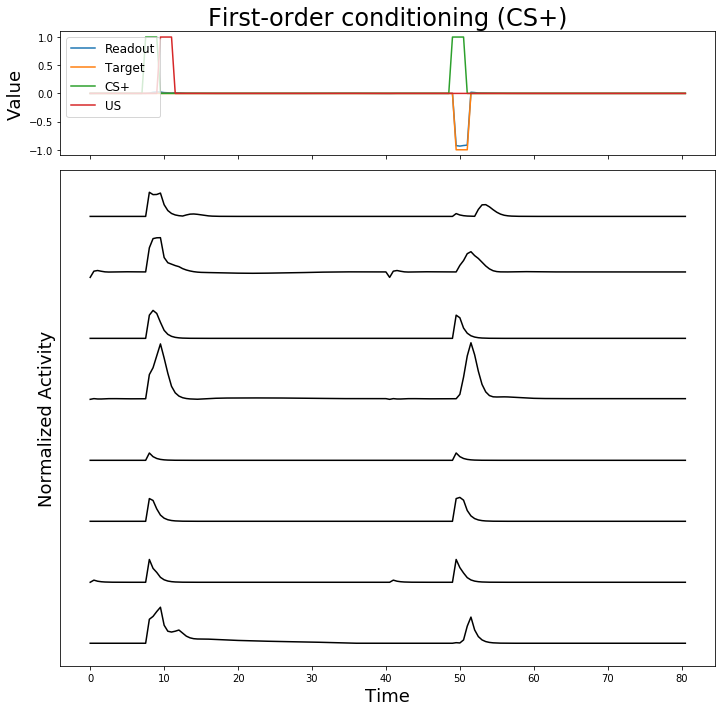

In [25]:
if net_type == 'first':
    trial_ls = [first_order_cond_csp, first_order_test]
    plt_ttl = 'First-order conditioning (CS+)'
    plt_lbl = (['CS+'], ['US'])
elif net_type == 'extend':
    plt_ttl = 'First-order conditioning (CS+)'
    plt_lbl = (['CS+', 'CS-'], ['US'])
elif net_type == 'no_plast':
    plt_ttl = 'No Plasticity'
    plt_lbl = (['CS+', 'CS-'], ['US'])
    trial_ls = [no_plasticity_trial]
elif net_type == 'continual':
    network = ContinualRNN()
T_int = 40
T_stim = 2
dt = 0.5
T_vars = (T_int, T_stim, dt)
plot_trial(network, trial_ls, plt_ttl, plt_lbl, T_vars, p_ctrl=0.5)


In [13]:
network.run_eval(trial_ls=trial_ls, n_trial=50, T_int=40, pos_val=None)
loss_hist = network.eval_loss
print(np.mean(loss_hist), np.std(loss_hist))


0.001071972133977397 0.0019836637511627666


In [14]:
# print(network.train_odors)
# print(network.W_readout)
# print(network.eval_rts[0][0, :network.n_mbon, :])
# print(network.eval_rts[1][0, :network.n_mbon, :])
print(network.eval_vts[0])
print(network.eval_vts[1])


tensor([ 0.0000e+00,  1.9135e-03,  2.2242e-03,  2.0691e-03,  1.4442e-03,
         1.2696e-03,  1.3078e-03,  1.3725e-03,  1.2672e-03,  1.0603e-03,
         9.0855e-04,  9.5701e-04,  1.0932e-03,  1.1991e-03,  1.2444e-03,
         1.2191e-03,  1.1533e-03,  1.0765e-03,  5.1079e-03,  1.8953e-02,
         2.4177e-02,  2.3339e-02,  1.3952e-02,  1.0924e-02,  8.8714e-03,
         1.1909e-02,  9.3191e-03,  5.7343e-03,  4.2324e-03,  3.6625e-03,
         2.8020e-03,  1.7353e-03,  2.0923e-03,  1.6853e-03,  6.0493e-04,
         1.0018e-03,  1.4840e-03,  1.5628e-03,  1.4429e-03,  1.3754e-03,
         1.4165e-03,  1.4465e-03,  1.4802e-03,  1.5888e-03,  1.6430e-03,
         1.6133e-03,  1.5410e-03,  1.4498e-03,  1.3842e-03,  1.3432e-03,
         1.3163e-03,  1.3030e-03,  1.3063e-03,  1.3240e-03,  1.3482e-03,
         1.3789e-03,  1.4137e-03,  1.4110e-03,  1.3797e-03,  1.3424e-03,
         1.3089e-03,  1.2762e-03,  1.2810e-03,  1.2552e-03,  1.4598e-03,
         1.7496e-03,  2.0044e-03,  2.2524e-03,  2.6